<a href="https://colab.research.google.com/github/rushikeshnaik779/EDA/blob/master/Eelo_SRK_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os 
import json
import numpy as np
import pandas as pd 
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt 
import seaborn as sns
color = sns.color_palette()

%matplotlib inline 

from plotly import tools 
import plotly.offline as py 
py.init_notebook_mode(connected=True)

import plotly.graph_objs as go 

from sklearn import model_selection, preprocessing, metrics 
import lightgbm as lgb 

pd.options.mode.chained_assignment = None 
pd.options.display.max_columns = 999

In [2]:
from google.colab import drive 

In [3]:
ndrive.mount('/content/gdrive')
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle
!kaggle competitions download -c elo-merchant-category-recommendation

Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle
 71% 9.00M/12.7M [00:00<00:00, 25.3MB/s]
100% 12.7M/12.7M [00:00<00:00, 25.7MB/s]
 98% 537M/548M [00:04<00:00, 140MB/s]
100% 548M/548M [00:04<00:00, 122MB/s]
 89% 44.0M/49.4M [00:00<00:00, 133MB/s]
100% 49.4M/49.4M [00:00<00:00, 142MB/s]
Data_Dictionary.xlsx: Skipping, found more recently modified local copy (use --force to force download)
  0% 0.00/1.13M [00:00<?, ?B/s]
100% 1.13M/1.13M [00:00<00:00, 35.7MB/s]
Data%20Dictionary.xlsx: Skipping, found more recently modified local copy (use --force to force download)
  0% 0.00/846k [00:00<?, ?B/s]
100% 846k/846k [00:00<00:00, 28.0MB/s]
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 49.6MB/s]


In [4]:
!ls 
!unzip \*.zip&& rm *.zip
!ls

Data%20Dictionary.xlsx		 new_merchant_transactions.csv.zip
Data_Dictionary.xlsx		 sample_submission.csv
historical_transactions.csv	 sample_submission.csv.zip
historical_transactions.csv.zip  test.csv
kaggle.json			 test.csv.zip
merchants.csv			 train.csv
merchants.csv.zip		 train.csv.zip
new_merchant_transactions.csv
Archive:  merchants.csv.zip
replace merchants.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Data%20Dictionary.xlsx		 new_merchant_transactions.csv.zip
Data_Dictionary.xlsx		 sample_submission.csv
historical_transactions.csv	 sample_submission.csv.zip
historical_transactions.csv.zip  test.csv
kaggle.json			 test.csv.zip
merchants.csv			 train.csv
merchants.csv.zip		 train.csv.zip
new_merchant_transactions.csv


So we are given the above files. The description of the files are 
- train.csv - training set
- test.csv - test set 
- sample_submission.csv - a sample submission file in the correct format - contains all card_ids you are expected to predict for. 
- historical _transaction.csv = upto 3 months worth of historical transactions for each card id
- merchants.csv - additional information about all merchants . merchant_ids in the dataset. 
- new_merchant_transaction.csv - two months worth of data for each card_id containing ALL purchase that card_id made merchant_ids that were not visited in the historical data . 

First let us explore the train and test set.

In [5]:
train_df = pd.read_csv('./train.csv', parse_dates=["first_active_month"])
test_df = pd.read_csv('./test.csv', parse_dates=['first_active_month'])

print('Number of rows and columns in train set:', train_df.shape)
print('Number of rows and columns in test set:', test_df.shape)

Number of rows and columns in train set: (201917, 6)
Number of rows and columns in test set: (123623, 5)


In [6]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


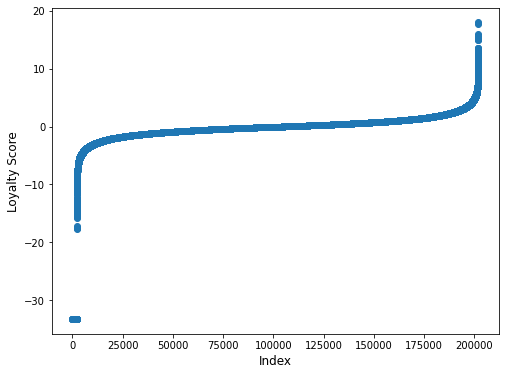

In [7]:
target_col = "target"

plt.figure(figsize=(8, 6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df[target_col].values))
plt.xlabel('Index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



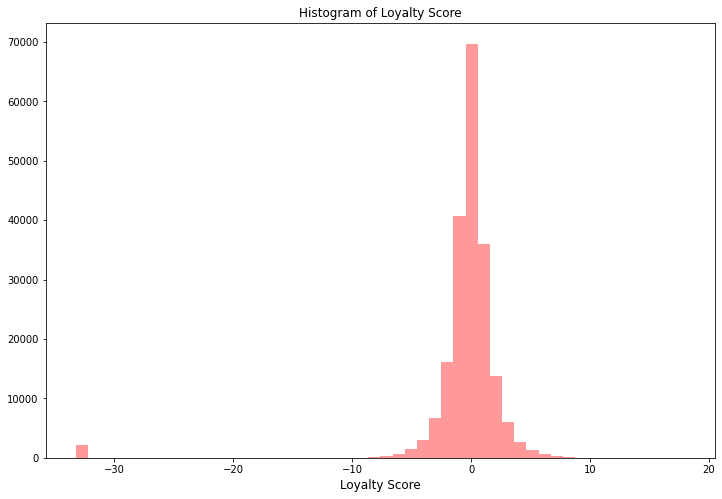

In [8]:
plt.figure(figsize=(12, 8))
sns.distplot(train_df[target_col].values, bins=50, kde=False, color='red')
plt.title("Histogram of Loyalty Score")
plt.xlabel('Loyalty Score', fontsize=12)
plt.show()

We can see that some of the loyalty values are far apart (less than -30) compared to others. Let us just get their count 

In [9]:
(train_df[target_col]<-30).sum()

2207


We have about 2207 rows (almost 1% of the data), which has values different from the rest. Since the metric RMSE these rows might play an important role. So beware of them 

### First Active Month 
In this section, let us see if there are any distribution change between train & test sets wuth respect to first active month of the card 



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



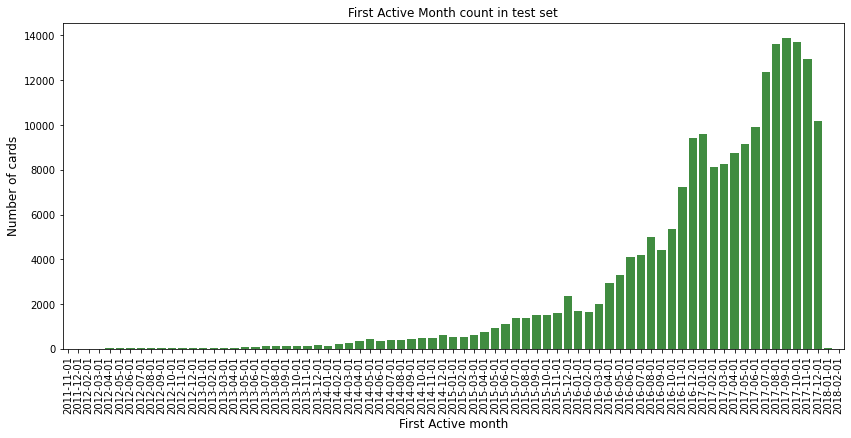

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



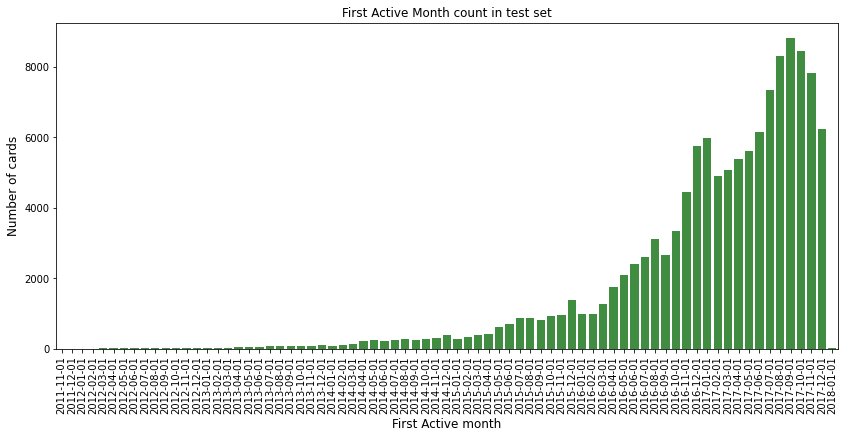

In [10]:
cnt_srs = train_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14, 6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First Active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title('First Active Month count in test set')
plt.show()

cnt_srs = test_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14, 6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First Active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title('First Active Month count in test set')
plt.show()

- Looks like the distribution is kind of similar between train and test set. So we need not really have to do time based split I think. 

In [11]:
# In this section, lets see if the other variables in the train dataset has good 
# predictive power in finding the loyalty score 

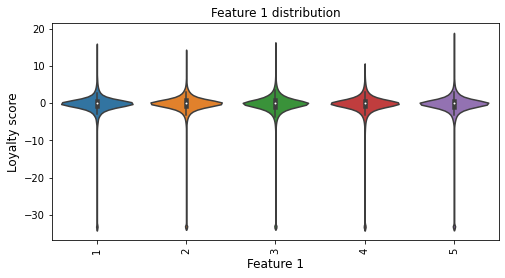

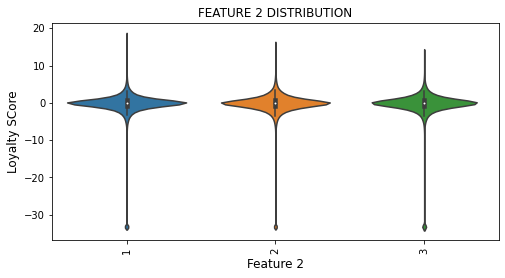

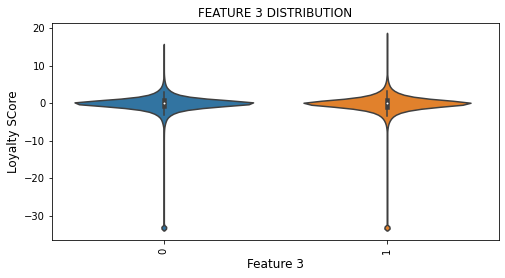

In [12]:
# Feature 1 
plt.figure(figsize=(8,4))
sns.violinplot(x='feature_1', y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 1 distribution")
plt.show()


# feature 2 
plt.figure(figsize=(8,4))
sns.violinplot(x='feature_2', y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2', fontsize=12)
plt.ylabel('Loyalty SCore', fontsize=12)
plt.title('FEATURE 2 DISTRIBUTION')
plt.show()


# feature 3 
plt.figure(figsize=(8, 4))
sns.violinplot(x='feature_3', y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3', fontsize=12)
plt.ylabel('Loyalty SCore', fontsize=12)
plt.title('FEATURE 3 DISTRIBUTION')
plt.show()

To the naked eyes, the distribution of the diffferent categories in all three features look kind of similar. Maybe the models are able to find the something here

In [13]:
# Historcical Transaction

# Now let us look at the historical transactions data for the cards 

In [14]:
hist_dff = pd.read_csv('./historical_transactions.csv')

In [15]:
hist_dff.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


The field description are as follows:
- card_id - Card identifier 
- month_lag - month lag to reference date
- purchase_date - Purchase date
- authorized_flag - Y if approved, N if denied 
- category_3 - anonymized category 
- installments - number of installments of purchase 
- category_1 - anonymized category 
- merchant_category_id - Merchant Category identifier 
- subsector_id - Merchant category group identifier 
- merchant_id - Merchant identifier 
- purchase_amount - Normalized purchase amount 
- city_id - City identifier (anonymized)
- state_id - State identifier (anonymized) 
- category_2 - anonymized category 

Now let us make some features based on the historical transactions and merge them with train and test set 

In [16]:
gdf = hist_dff.groupby("card_id")
gdf = gdf['purchase_amount'].size().reset_index()
gdf.columns = ["card_id", "num_hist_transactions"]

train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

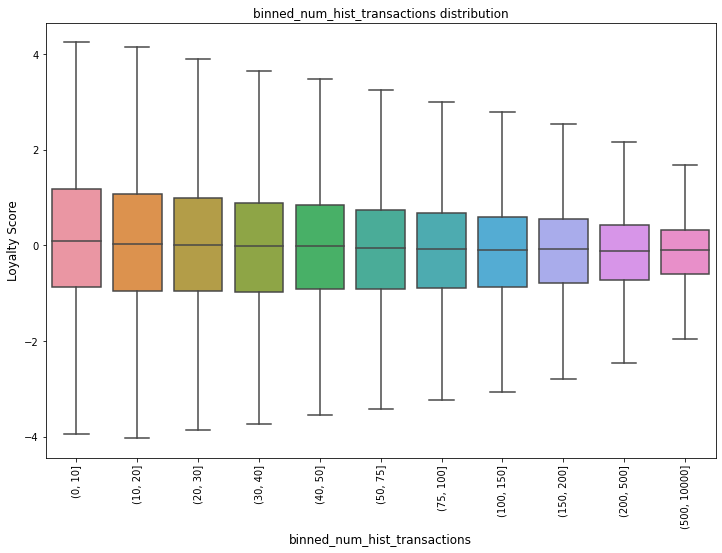

In [24]:
cnt_srs = train_df.groupby("num_hist_transactions")[target_col].mean()
cnt_srs = cnt_srs.sort_index()
cnt_srs = cnt_srs[: -50]
# now let us bin the count of historical transactions and then do some box plots 
# to see the plots better 

bins = [0,10,20,30,40,50, 75,100,150,200,500,10000]
train_df['binned_num_hist_transactions'] = pd.cut(
    train_df['num_hist_transactions'],
     bins)

cnt_srs = train_df.groupby("binned_num_hist_transactions")[target_col].mean()

plt.figure(figsize=(12, 8))

sns.boxplot(x='binned_num_hist_transactions', y=target_col, data=train_df, showfliers=False)

plt.xticks(rotation='vertical')
plt.xlabel('binned_num_hist_transactions', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.title('binned_num_hist_transactions distribution')
plt.show()

### Value of Historical Transactions 
Now let us check the value of the historical transactions for the cards and check the loyalty score distribution based on that.

In [25]:
gdf = hist_dff.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()

gdf.columns = ["card_id", "sum_hist_trans", "mean_hist_trans", "std_hist_trans",
               "min_hist_trans", "max_hist_trans"]

train_df = pd.merge(train_df, gdf, on='card_id', how="left")
test_df = pd.merge(test_df, gdf, on='card_id', how='left')

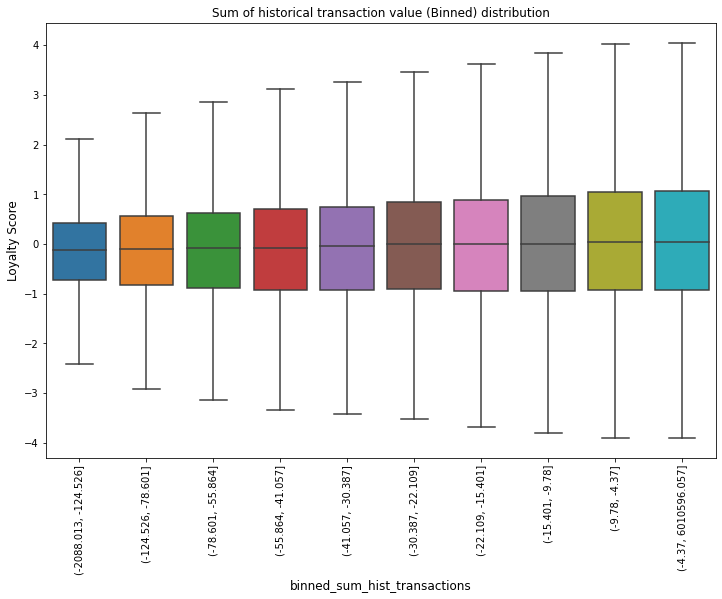

In [26]:
bins = np.percentile(train_df['sum_hist_trans'], range(0, 101, 10))
train_df['binned_sum_hist_transactions'] = pd.cut(train_df['sum_hist_trans'],
                                                  bins)
# cnt_srs train_df.groupby("binned_num_hist_transactions")[target_col].mean()

plt.figure(figsize=(12, 8))
sns.boxplot(x='binned_sum_hist_transactions', y=target_col, data=train_df, 
            showfliers = False)

plt.xticks(rotation='vertical')
plt.xlabel('binned_sum_hist_transactions', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.title('Sum of historical transaction value (Binned) distribution')
plt.show()

In [27]:
# As we could see the loyalty score seems to increase with the sum of
# historical transaction value this is expected now we can do the same plot with "Mean value of historical transaction"

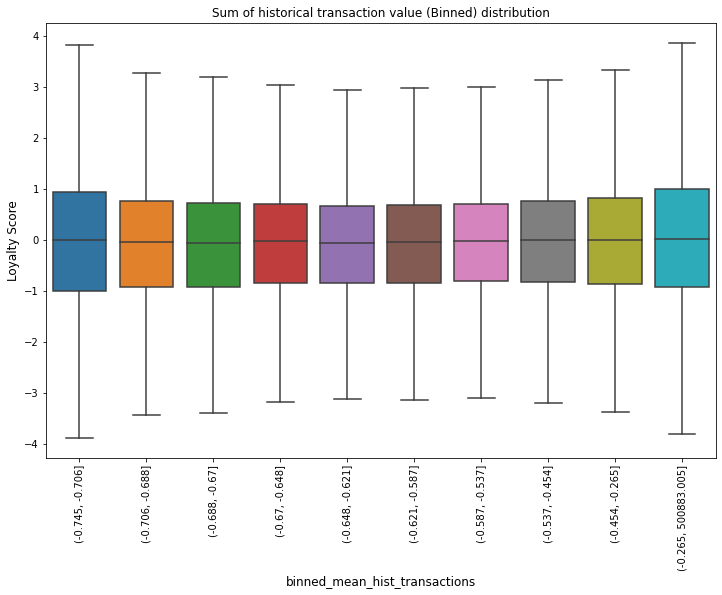

In [28]:
bins = np.percentile(train_df['mean_hist_trans'], range(0, 101, 10))
train_df['binned_mean_hist_transactions'] = pd.cut(train_df['mean_hist_trans'],
                                                  bins)
# cnt_srs train_df.groupby("binned_num_hist_transactions")[target_col].mean()

plt.figure(figsize=(12, 8))
sns.boxplot(x='binned_mean_hist_transactions', y=target_col, data=train_df, 
            showfliers = False)

plt.xticks(rotation='vertical')
plt.xlabel('binned_mean_hist_transactions', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.title('Sum of historical transaction value (Binned) distribution')
plt.show()

In [29]:
# New Merchant transactions 

# In this section, let us look at the new merchant transactions data and do some 
# analysis


In [32]:
new_trans_df = pd.read_csv('new_merchant_transactions.csv')
new_trans_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [33]:
gdf = new_trans_df.groupby('card_id')
gdf = gdf['purchase_amount'].size().reset_index()
gdf.columns = ['card_id', 'num_merch_transactions']
train_df = pd.merge(train_df, gdf, on='card_id', how='left')
test_df = pd.merge(test_df, gdf, on='card_id', how='left')

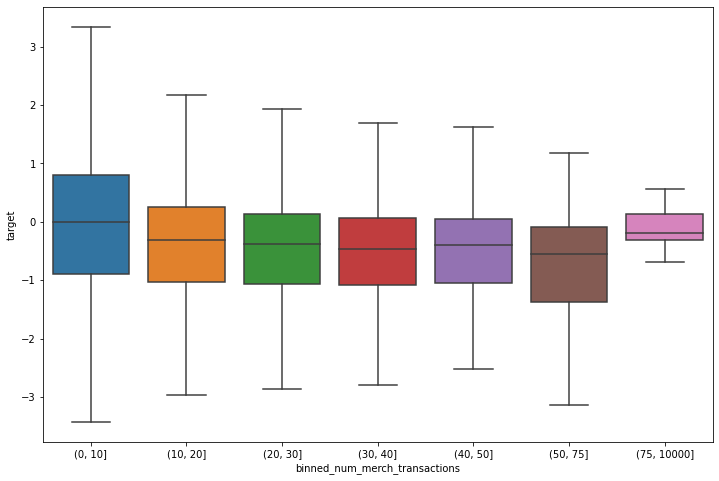

In [35]:
bins = [0, 10, 20, 30, 40, 50, 75, 10000]

train_df['binned_num_merch_transactions'] = pd.cut(
    train_df['num_merch_transactions'], bins)

cnt_srs = train_df.groupby('binned_num_merch_transactions')[target_col].mean()


plt.figure(figsize=(12,8))
sns.boxplot(x='binned_num_merch_transactions', y=target_col, data=train_df,
            showfliers= False)



In [36]:
# Loyalty score seem to decrease as the number of new merchant transactions
# increases except for the last bin


gdf = hist_dff.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()

gdf.columns = ["card_id", "sum_merch_trans", "mean_merch_trans", "std_merch_trans",
               "min_merch_trans", "max_merch_trans"]

train_df = pd.merge(train_df, gdf, on='card_id', how="left")
test_df = pd.merge(test_df, gdf, on='card_id', how='left')

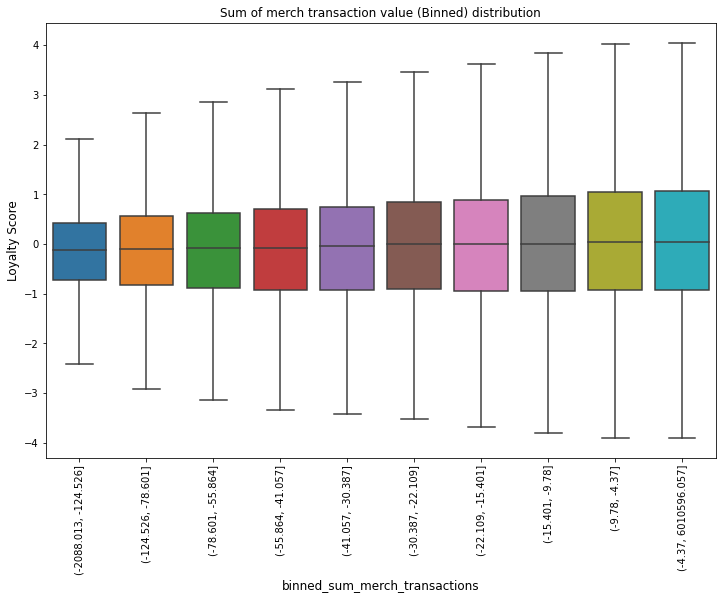

In [37]:
bins = np.percentile(train_df['sum_merch_trans'], range(0, 101, 10))
train_df['binned_sum_merch_transactions'] = pd.cut(train_df['sum_merch_trans'],
                                                  bins)
# cnt_srs train_df.groupby("binned_num_hist_transactions")[target_col].mean()

plt.figure(figsize=(12, 8))
sns.boxplot(x='binned_sum_merch_transactions', y=target_col, data=train_df, 
            showfliers = False)

plt.xticks(rotation='vertical')
plt.xlabel('binned_sum_merch_transactions', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.title('Sum of merch transaction value (Binned) distribution')
plt.show()

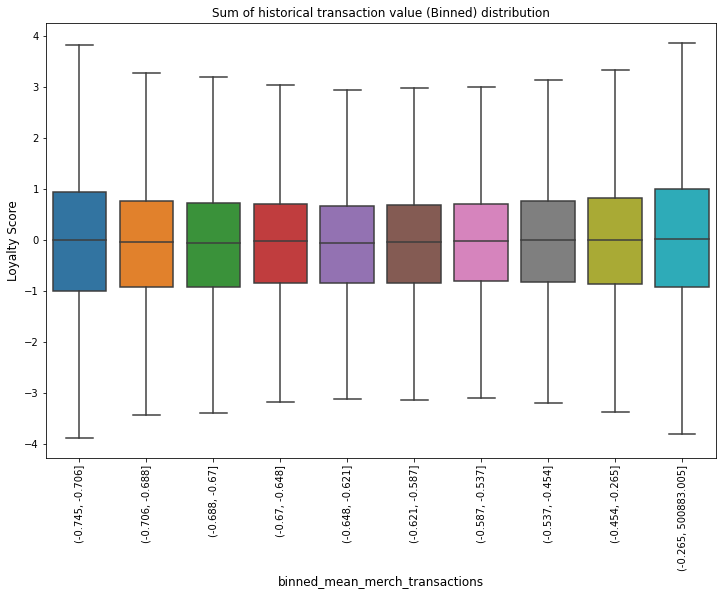

In [38]:
bins = np.nanpercentile(train_df['mean_merch_trans'], range(0, 101, 10))
train_df['binned_mean_merch_transactions'] = pd.cut(train_df['mean_merch_trans'],
                                                  bins)
# cnt_srs train_df.groupby("binned_num_hist_transactions")[target_col].mean()

plt.figure(figsize=(12, 8))
sns.boxplot(x='binned_mean_merch_transactions', y=target_col, data=train_df, 
            showfliers = False)

plt.xticks(rotation='vertical')
plt.xlabel('binned_mean_merch_transactions', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.title('Sum of historical transaction value (Binned) distribution')
plt.show()

In [39]:
# Lets build one base line model 


In [40]:
train_df["year"] = train_df["first_active_month"].dt.year
test_df["year"] = test_df["first_active_month"].dt.year
train_df["month"] = train_df["first_active_month"].dt.month
test_df["month"] = test_df["first_active_month"].dt.month

cols_to_use = ["feature_1", "feature_2", "feature_3", "year", "month", 
               "num_hist_transactions", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", 
               "min_hist_trans", "max_hist_trans",
               "num_merch_transactions", "sum_merch_trans", "mean_merch_trans", "std_merch_trans",
               "min_merch_trans", "max_merch_trans",
              ]

In [41]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "min_child_weight" : 50,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

train_X = train_df[cols_to_use]
test_X = test_df[cols_to_use]
train_y = train_df[target_col].values

pred_test = 0
kf = model_selection.KFold(n_splits=5, random_state=2018, shuffle=True)
for dev_index, val_index in kf.split(train_df):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_test_tmp, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test += pred_test_tmp
pred_test /= 5.
    

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.82941
[200]	valid_0's rmse: 3.82813
[300]	valid_0's rmse: 3.82913
Early stopping, best iteration is:
[207]	valid_0's rmse: 3.82793
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.77528
[200]	valid_0's rmse: 3.77537
Early stopping, best iteration is:
[118]	valid_0's rmse: 3.77429
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.8232
[200]	valid_0's rmse: 3.82213
[300]	valid_0's rmse: 3.82289
Early stopping, best iteration is:
[203]	valid_0's rmse: 3.82207
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.81385
[200]	valid_0's rmse: 3.81356
Early stopping, best iteration is:
[145]	valid_0's rmse: 3.81246
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.87542
[200]	valid_0's rmse: 3.87632
Early stopping, best iteration is:
[131]	valid_0's rmse: 3.87508


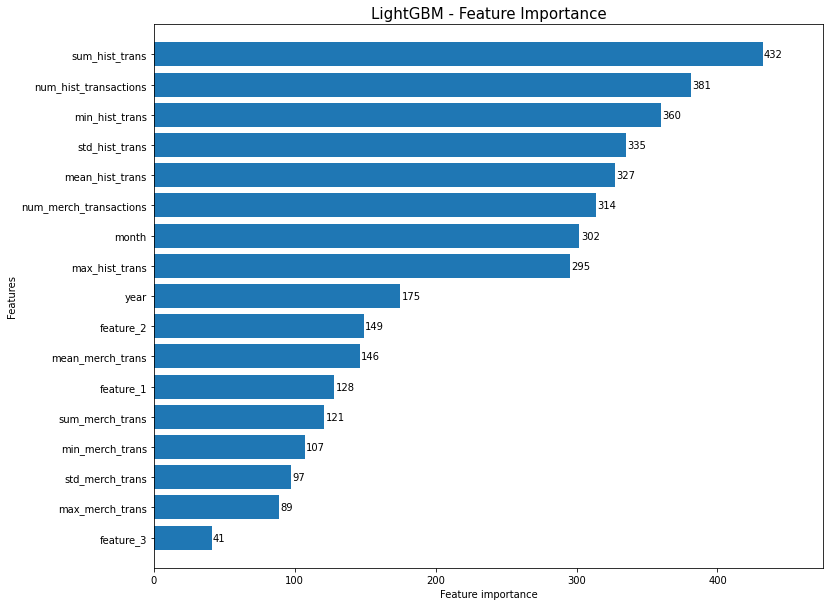

In [42]:
fig, ax = plt.subplots(figsize=(12, 10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()